In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
#load data
data = pd.read_csv('train/demo_walk_9_train.csv', index_col=0)

X = data.drop(['right_touch', 'left_touch'], axis=1)
y = data[['right_touch', 'left_touch']]

# Use train_test_split with stratify parameter
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Convert pandas DataFrames to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [3]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

input_size = X_train.shape[1]
hidden_size = 64  # You can adjust this based on your problem
output_size = 2  # Assuming binary classification for each foot

# Instantiate the model
model = NN(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [4]:
# Convert data to DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [5]:
num_epochs = 250

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss for every epoch
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model on the test set
with torch.no_grad():
    model.eval()
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Epoch [10/250], Loss: 0.6423
Epoch [20/250], Loss: 0.5831
Epoch [30/250], Loss: 0.5551
Epoch [40/250], Loss: 0.5048
Epoch [50/250], Loss: 0.4152
Epoch [60/250], Loss: 0.3920
Epoch [70/250], Loss: 0.3582
Epoch [80/250], Loss: 0.3077
Epoch [90/250], Loss: 0.2701
Epoch [100/250], Loss: 0.2377
Epoch [110/250], Loss: 0.2274
Epoch [120/250], Loss: 0.1883
Epoch [130/250], Loss: 0.2370
Epoch [140/250], Loss: 0.2353
Epoch [150/250], Loss: 0.1856
Epoch [160/250], Loss: 0.2049
Epoch [170/250], Loss: 0.1790
Epoch [180/250], Loss: 0.1947
Epoch [190/250], Loss: 0.1845
Epoch [200/250], Loss: 0.1917
Epoch [210/250], Loss: 0.1435
Epoch [220/250], Loss: 0.1538
Epoch [230/250], Loss: 0.1754
Epoch [240/250], Loss: 0.1353
Epoch [250/250], Loss: 0.1718
Test Loss: 0.1730


In [6]:
#predict on train set
with torch.no_grad():
    model.eval()
    train_outputs = model(X_train_tensor)
    train_loss = criterion(train_outputs, y_train_tensor)
    print(f'Train Loss: {train_loss.item():.4f}')
    

Train Loss: 0.1349


In [7]:
#plot output
# plt.figure(figsize=(8, 6))
# plt.plot(train_outputs[:, 0], label='Predicted Right')
# plt.plot(y_train_tensor[:, 0], label='Actual Right')
# plt.legend()
# plt.show()

# plt.figure(figsize=(8, 6))
# plt.plot(train_outputs[:, 1], label='Predicted Left')
# plt.plot(y_train_tensor[:, 1], label='Actual Left')
# plt.legend()
# plt.show()


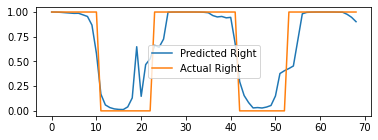

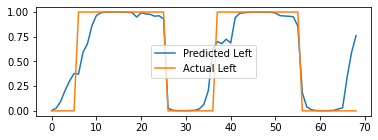

In [8]:
#predict on full set
X_full = torch.tensor(X.values, dtype=torch.float32)
X_full_outputs = model(X_full)
X_np = X_full_outputs.detach().numpy()

#plot output
plt.figure(figsize=(6, 2))
plt.plot(X_np[:, 0], label='Predicted Right')
plt.plot(y.right_touch, label='Actual Right')
plt.legend()
plt.figure(figsize=(6, 2))
plt.plot(X_np[:, 1], label='Predicted Left')
plt.plot(y.left_touch, label='Actual Left')
plt.legend()
plt.show()


In [9]:
#round predictions
X_full_outputs_round = torch.round(X_full_outputs)

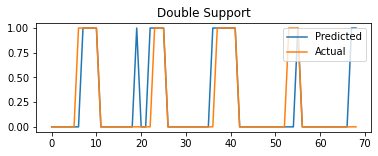

In [10]:
#calculate double support by looking at when both feet are touching (1,1)
ds = []
for i in range(len(X_full_outputs_round)):
    if X_full_outputs_round[i][0] == 1 and X_full_outputs_round[i][1] == 1:
        ds.append(1)
    else:
        ds.append(0)

ds_true = []
for i in range(len(y)):
    if y.right_touch[i] == 1 and y.left_touch[i] == 1:
        ds_true.append(1)
    else:
        ds_true.append(0)

#plot double support
plt.figure(figsize=(6, 2))
plt.plot(ds, label='Predicted')
plt.plot(ds_true, label='Actual')
plt.legend()
plt.title('Double Support')
plt.show()


In [11]:
#calculate percentege of 1s in predictions
print('Predicted Double Support:', sum(ds)/len(ds))
print('Actual Double Support:', sum(ds_true)/len(ds_true))

Predicted Double Support: 0.2608695652173913
Actual Double Support: 0.2318840579710145


In [12]:
import joblib

#load original data
track_dict = joblib.load('data/demo_walk_9.pkl')

def get_cameras(dict):
    frames = list(dict.keys())
    joints_2d = []
    for frame in frames:
        joints_2d.append(dict.get(frame).get('camera'))
    
    return np.array(joints_2d)

In [13]:
camera_frames = get_cameras(track_dict).reshape(get_cameras(track_dict).shape[0], -1)
x_coords = camera_frames[:, 0::3]

In [14]:
left_touch_pred = X_full_outputs_round[:, 1].detach().numpy()

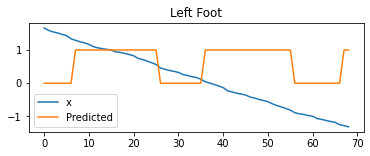

In [15]:
#plot right foot
plt.figure(figsize=(6, 2))
plt.plot(x_coords[:, 0], label='x')
plt.plot(left_touch_pred, label='Predicted')
plt.legend()
plt.title('Left Foot')
plt.show()

In [16]:
print(left_touch_pred[7])
print(left_touch_pred[36])

1.0
1.0


In [17]:
#get distance between feet
x_coords[7] - x_coords[36]

array([1.2457266], dtype=float32)

In [18]:
x_coords[0] - x_coords[-1]

array([2.9737515], dtype=float32)

In [20]:
2.9/(69/30)

1.2608695652173914